In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import bartz
from stochtree import BARTModel
from bart_playground import *

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import arviz as az
import time

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [4]:
import numpy as np

def data_truncated(n_samples=400, random_state=42, upper=3):
    np.random.seed(random_state)
    X = np.random.uniform(-2, 2, (n_samples, 3))
    noise = np.random.normal(0, 0.3, n_samples)
    y = X[:, 0] + X[:, 1] + X[:, 2] + noise
    y = np.minimum(y, upper)
    return X, y

X, y = data_truncated()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

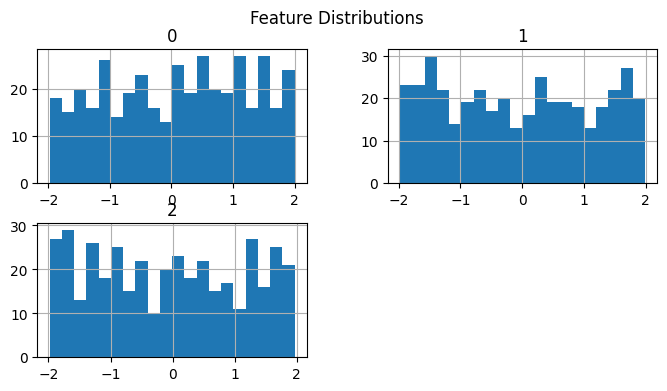

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X_df = pd.DataFrame(X)
X_df.hist(figsize=(8, 4), bins=20)
plt.suptitle("Feature Distributions")
plt.show()

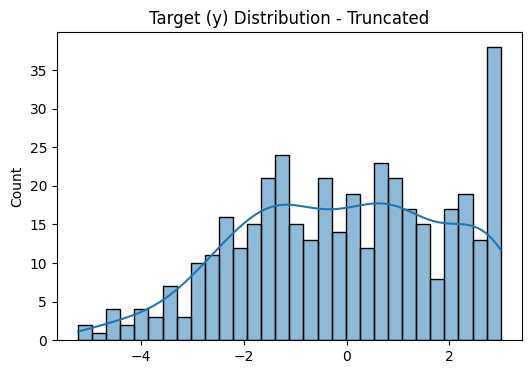

In [6]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True, bins=30)
plt.title("Target (y) Distribution - Truncated")
plt.show()

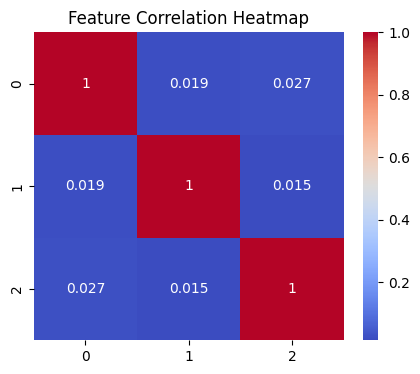

In [7]:
plt.figure(figsize=(5, 4))
corr = X_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Gelman-Rubin R

In [8]:
n_chains = 4
chains_mtmh = []
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
for i in range(n_chains):
    bart = MultiBART(ndpost=1000, nskip=1000, n_trees=100, proposal_probs=proposal_probs, multi_tries=10, random_state=i)
    bart.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'][0] for trace in bart.sampler.trace]
    chains_mtmh.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_mtmh)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 2000/2000 [01:48<00:00, 18.48it/s]


Gelman-Rubin R̂: <xarray.Dataset> Size: 8B
Dimensions:     ()
Data variables:
    eps_sigma2  float64 8B 1.084


In [9]:
n_chains = 4
chains_default = []
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
for i in range(n_chains):
    bart_default = DefaultBART(ndpost=1000, nskip=100, n_trees=100, proposal_probs=proposal_probs, random_state=i)
    bart_default.fit(X_train, y_train)
    sigmas = [trace.global_params['eps_sigma2'] for trace in bart_default.sampler.trace]
    chains_default.append(sigmas)

# chains: shape (n_chains, n_samples)
chains_array = np.array(chains_default)
idata = az.from_dict(posterior={"eps_sigma2": chains_array})
rhat = az.rhat(idata, var_names=["eps_sigma2"])
print("Gelman-Rubin R̂:", rhat)

Iterations: 100%|██████████| 1100/1100 [00:10<00:00, 104.38it/s]

Gelman-Rubin R̂: <xarray.Dataset> Size: 16B
Dimensions:           (eps_sigma2_dim_0: 1)
Coordinates:
  * eps_sigma2_dim_0  (eps_sigma2_dim_0) int64 8B 0
Data variables:
    eps_sigma2        (eps_sigma2_dim_0) float64 8B 1.156


# Trace plot

In [10]:
proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
bart_mtmh = MultiBART(ndpost=1000, nskip=0, n_trees=100, proposal_probs=proposal_probs, multi_tries=10)
bart_mtmh.fit(X_train, y_train)
sigmas_mtmh = [trace.global_params['eps_sigma2'] for trace in bart_mtmh.sampler.trace]
means_mtmh = [trace.evaluate(X_train).mean() for trace in bart_mtmh.sampler.trace]
first_preds_mtmh = [trace.evaluate(X_train[0:1])[0] for trace in bart_mtmh.sampler.trace]

Iterations: 100%|██████████| 1000/1000 [00:53<00:00, 18.84it/s]


In [11]:
proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
bart_default = DefaultBART(ndpost=1000, nskip=0, n_trees=100, proposal_probs=proposal_probs)
bart_default.fit(X_train, y_train)
sigmas_default = [trace.global_params['eps_sigma2'] for trace in bart_default.sampler.trace]
means_default = [trace.evaluate(X_train).mean() for trace in bart_default.sampler.trace]
first_preds_default = [trace.evaluate(X_train[0:1])[0] for trace in bart_default.sampler.trace]

Iterations: 100%|██████████| 1000/1000 [00:10<00:00, 96.43it/s]


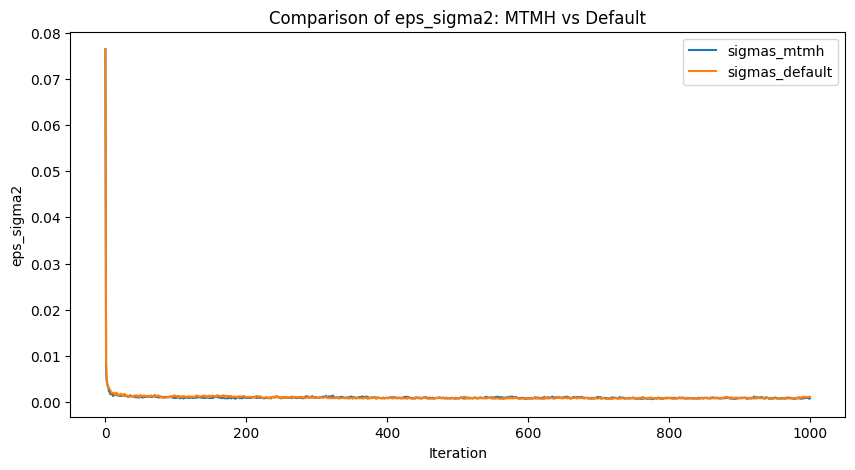

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(sigmas_mtmh, label='sigmas_mtmh')
plt.plot(sigmas_default, label='sigmas_default')
plt.xlabel('Iteration')
plt.ylabel('eps_sigma2')
plt.legend()
plt.title('Comparison of eps_sigma2: MTMH vs Default')
plt.show()

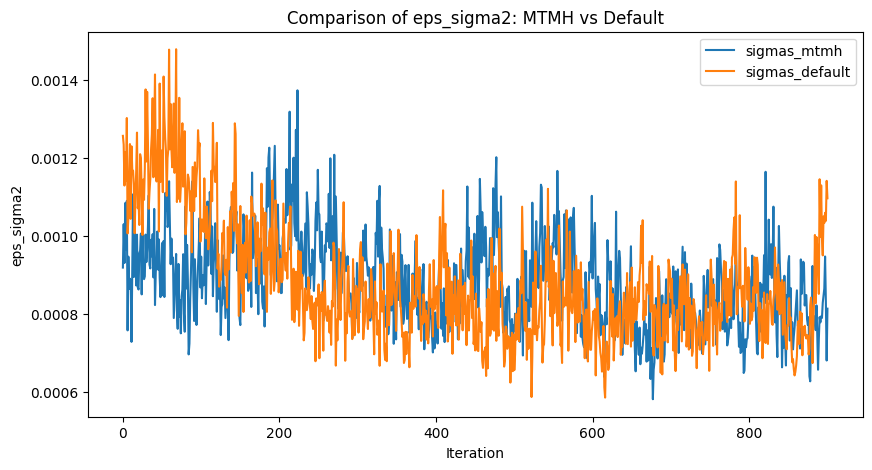

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(sigmas_mtmh[100:], label='sigmas_mtmh')
plt.plot(sigmas_default[100:], label='sigmas_default')
plt.xlabel('Iteration')
plt.ylabel('eps_sigma2')
plt.legend()
plt.title('Comparison of eps_sigma2: MTMH vs Default')
plt.show()

# MSE

In [14]:
test_mse_results = {name: [] for name in ["bart_mtmh", "bart", "btz", "rf", "xgb"]}
train_mse_results = {name: [] for name in ["bart_mtmh", "bart", "btz", "rf", "xgb"]}
pi_length_results = {name: [] for name in ["bart_mtmh", "bart", "btz"]}
coverage_results = {name: [] for name in ["bart_mtmh", "bart", "btz"]}
time_results = {name: [] for name in ["bart_mtmh", "bart", "btz", "rf", "xgb"]}

In [15]:
n_runs = 5
n_skip = 1000
n_post = 1000
n_trees = 100

for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    
    
    # bart_mtmh
    t0 = time.time()
    proposal_probs = {"multi_grow": 0.25, "multi_prune": 0.25, "multi_change": 0.4, "multi_swap": 0.1}
    bart_mtmh = MultiBART(ndpost=n_post, nskip=n_skip, n_trees=n_trees, proposal_probs=proposal_probs, multi_tries=10, random_state=seed)
    bart_mtmh.fit(X_train, y_train)
    time_results["bart_mtmh"].append(time.time() - t0)
    
    # bart_default
    t0 = time.time()
    proposal_probs = {"grow": 0.25, "prune": 0.25, "change": 0.4, "swap": 0.1}
    bart = DefaultBART(ndpost=n_post, nskip=n_skip, n_trees=n_trees, proposal_probs=proposal_probs, random_state=seed)
    bart.fit(X_train, y_train)
    time_results["bart"].append(time.time() - t0)
    
    # btz
    t0 = time.time()
    btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=n_trees, ndpost=n_post, nskip=n_skip, seed=seed)
    btpred_all_test = btz.predict(np.transpose(X_test))
    btpred_all_test = np.array(btpred_all_test)
    btpred_test = np.mean(np.array(btpred_all_test), axis=0)
    btpred_all_train = btz.predict(np.transpose(X_train))
    btpred_train = np.mean(np.array(btpred_all_train), axis=0)
    time_results["btz"].append(time.time() - t0)
    
    # # sto
    # t0 = time.time()
    # sto = BARTModel()
    # sto.sample(X_train=X_train, y_train=y_train,
    #            num_gfr=0, num_burnin=n_skip, num_mcmc=n_post, 
    #            mean_forest_params={"num_trees": n_trees}, 
    #            general_params = {"random_seed": seed},
    #            variance_forest_params={"num_trees": n_trees // 2}) 
    # sto_pred_all_test, sto_all_sigma = sto.predict(X_test)
    # sto_pred_test = np.mean(sto_pred_all_test, axis=1)
    # sto_pred_train = np.mean(sto.predict(X_train)[0], axis=1)
    # time_results["sto"].append(time.time() - t0)

    # rf
    t0 = time.time()
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=seed)
    rf.fit(X_train, y_train)
    time_results["rf"].append(time.time() - t0)

    # xgb
    t0 = time.time()
    xgbr = xgb.XGBRegressor(n_estimators=n_trees, random_state=seed, verbosity=0)
    xgbr.fit(X_train, y_train)
    time_results["xgb"].append(time.time() - t0)

    
    # Test MSE
    test_mse_results["bart_mtmh"].append(mean_squared_error(y_test, bart_mtmh.predict(X_test)))
    test_mse_results["bart"].append(mean_squared_error(y_test, bart.predict(X_test)))
    test_mse_results["btz"].append(mean_squared_error(y_test, btpred_test))
    # test_mse_results["sto"].append(mean_squared_error(y_test, sto_pred_test))
    test_mse_results["rf"].append(mean_squared_error(y_test, rf.predict(X_test)))
    test_mse_results["xgb"].append(mean_squared_error(y_test, xgbr.predict(X_test)))


    # Train MSE
    train_mse_results["bart_mtmh"].append(mean_squared_error(y_train, bart_mtmh.predict(X_train)))
    train_mse_results["bart"].append(mean_squared_error(y_train, bart.predict(X_train)))
    train_mse_results["btz"].append(mean_squared_error(y_train, btpred_train))
    # train_mse_results["sto"].append(mean_squared_error(y_train, sto_pred_train))
    train_mse_results["rf"].append(mean_squared_error(y_train, rf.predict(X_train)))
    train_mse_results["xgb"].append(mean_squared_error(y_train, xgbr.predict(X_train)))


    # Prediction intervals
    # btz: axis=0, shape (n_mcmc, n_test)
    eps = np.zeros_like(btpred_all_test)
    for i in range(n_post):
        eps[i] = np.random.normal(0, btz.sigma[i], size=btpred_all_test.shape[1])
        btpred_all_test[i, :] += eps[i]    
    btz_lower = np.percentile(btpred_all_test, 2.5, axis=0)
    btz_upper = np.percentile(btpred_all_test, 97.5, axis=0)
    pi_length_results["btz"].append(np.mean(btz_upper - btz_lower))
    btz_covered = ((y_test >= btz_lower) & (y_test <= btz_upper)).mean()
    coverage_results["btz"].append(btz_covered)
    
    # # sto: axis=1, shape (n_test, n_mcmc)
    # sto_eps = np.zeros_like(sto_pred_all_test)
    # for i in range(n_post):
    #     sto_eps[:, i] = np.random.normal(np.zeros(sto_pred_all_test.shape[0]), sto_all_sigma[:, i])
    #     sto_pred_all_test[:, i] += sto_eps[:, i]
    # sto_lower = np.percentile(sto_pred_all_test, 2.5, axis=1)
    # sto_upper = np.percentile(sto_pred_all_test, 97.5, axis=1)
    # pi_length_results["sto"].append(np.mean(sto_upper - sto_lower))
    # sto_covered = ((y_test >= sto_lower) & (y_test <= sto_upper)).mean()
    # coverage_results["sto"].append(sto_covered)
    
    # bart: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart.posterior_predict(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart"].append(np.mean(bart_upper - bart_lower))
    bart_covered = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
    coverage_results["bart"].append(bart_covered)

    # bart_mtmh: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart_mtmh.posterior_predict(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart_mtmh"].append(np.mean(bart_upper - bart_lower))
    bart_covered = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
    coverage_results["bart_mtmh"].append(bart_covered)

Iterations: 100%|██████████| 2000/2000 [00:20<00:00, 97.54it/s] 
INFO:2025-11-26 14:06:40,816:jax._src.xla_bridge:752: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


....................................................................................................
It 100/2000 grow P=61% A=20%, prune P=39% A=18%, fill=6% (burnin)
....................................................................................................
It 200/2000 grow P=61% A=23%, prune P=39% A=26%, fill=6% (burnin)
....................................................................................................
It 300/2000 grow P=56% A=23%, prune P=44% A=25%, fill=6% (burnin)
....................................................................................................
It 400/2000 grow P=55% A=18%, prune P=45% A=31%, fill=6% (burnin)
....................................................................................................
It 500/2000 grow P=51% A=16%, prune P=49% A=33%, fill=6% (burnin)
....................................................................................................
It 600/2000 grow P=46% A=17%, prune P=54% A=20%, fill=6% (burnin

Iterations: 100%|██████████| 2000/2000 [00:18<00:00, 110.14it/s]


....................................................................................................
It 100/2000 grow P=53% A=19%, prune P=47% A=36%, fill=6% (burnin)
....................................................................................................
It 200/2000 grow P=58% A=21%, prune P=42% A=17%, fill=6% (burnin)
....................................................................................................
It 300/2000 grow P=58% A=26%, prune P=42% A=24%, fill=6% (burnin)
....................................................................................................
It 400/2000 grow P=59% A=14%, prune P=41% A=22%, fill=6% (burnin)
....................................................................................................
It 500/2000 grow P=52% A=17%, prune P=48% A=21%, fill=6% (burnin)
....................................................................................................
It 600/2000 grow P=51% A=27%, prune P=49% A=18%, fill=6% (burnin

Iterations: 100%|██████████| 2000/2000 [00:22<00:00, 90.91it/s] 


....................................................................................................
It 100/2000 grow P=47% A=21%, prune P=53% A=25%, fill=6% (burnin)
....................................................................................................
It 200/2000 grow P=44% A=23%, prune P=56% A=27%, fill=6% (burnin)
....................................................................................................
It 300/2000 grow P=52% A=27%, prune P=48% A=25%, fill=6% (burnin)
....................................................................................................
It 400/2000 grow P=56% A=32%, prune P=44% A=32%, fill=6% (burnin)
....................................................................................................
It 500/2000 grow P=49% A=6%, prune P=51% A=27%, fill=6% (burnin)
....................................................................................................
It 600/2000 grow P=44% A=23%, prune P=56% A=30%, fill=6% (burnin)

Iterations: 100%|██████████| 2000/2000 [00:21<00:00, 94.10it/s] 


....................................................................................................
It 100/2000 grow P=48% A=25%, prune P=52% A=13%, fill=6% (burnin)
....................................................................................................
It 200/2000 grow P=47% A=21%, prune P=53% A=30%, fill=6% (burnin)
....................................................................................................
It 300/2000 grow P=49% A=22%, prune P=51% A=25%, fill=6% (burnin)
....................................................................................................
It 400/2000 grow P=50% A=28%, prune P=50% A=12%, fill=6% (burnin)
....................................................................................................
It 500/2000 grow P=47% A=21%, prune P=53% A=32%, fill=6% (burnin)
....................................................................................................
It 600/2000 grow P=49% A=22%, prune P=51% A=18%, fill=7% (burnin

Iterations: 100%|██████████| 2000/2000 [00:20<00:00, 98.93it/s] 


....................................................................................................
It 100/2000 grow P=54% A=17%, prune P=46% A=35%, fill=6% (burnin)
....................................................................................................
It 200/2000 grow P=57% A=23%, prune P=43% A=33%, fill=6% (burnin)
....................................................................................................
It 300/2000 grow P=59% A=22%, prune P=41% A=22%, fill=6% (burnin)
....................................................................................................
It 400/2000 grow P=47% A=23%, prune P=53% A=15%, fill=6% (burnin)
....................................................................................................
It 500/2000 grow P=57% A=19%, prune P=43% A=19%, fill=6% (burnin)
....................................................................................................
It 600/2000 grow P=56% A=16%, prune P=44% A=23%, fill=6% (burnin

In [16]:
import pandas as pd

test_mse_df = pd.DataFrame(test_mse_results)
train_mse_df = pd.DataFrame(train_mse_results)
pi_length_df = pd.DataFrame(pi_length_results)
coverage_df = pd.DataFrame(coverage_results)
time_df = pd.DataFrame(time_results)

print(f"Test MSE ({n_runs} runs):")
print(f"Train MSE ({n_runs} runs):")
print("Test MSE Mean:")
print(test_mse_df.mean())
print("Train MSE Mean:")
print(train_mse_df.mean())

print(f"Prediction Interval Mean Length ({n_runs} runs):")
print(f"Prediction Interval Mean Length (Mean over {n_runs} runs):")
print(pi_length_df.mean())

print(f"Prediction Interval Coverage Mean ({n_runs} runs):")
print(coverage_df.mean())

print(f"Average Training Time (seconds) over {n_runs} runs:")
print(time_df.mean())

Test MSE (5 runs):
Train MSE (5 runs):
Test MSE Mean:
bart_mtmh    0.132527
bart         0.141431
btz          0.135243
rf           0.221437
xgb          0.226324
dtype: float64
Train MSE Mean:
bart_mtmh    0.026563
bart         0.027227
btz          0.027752
rf           0.031016
xgb          0.000018
dtype: float64
Prediction Interval Mean Length (5 runs):
Prediction Interval Mean Length (Mean over 5 runs):
bart_mtmh    1.269227
bart         1.216990
btz          1.319026
dtype: float64
Prediction Interval Coverage Mean (5 runs):
bart_mtmh    0.922
bart         0.878
btz          0.922
dtype: float64
Average Training Time (seconds) over 5 runs:
bart_mtmh    111.527319
bart          20.573246
btz           19.983114
rf             0.171149
xgb            0.142235
dtype: float64


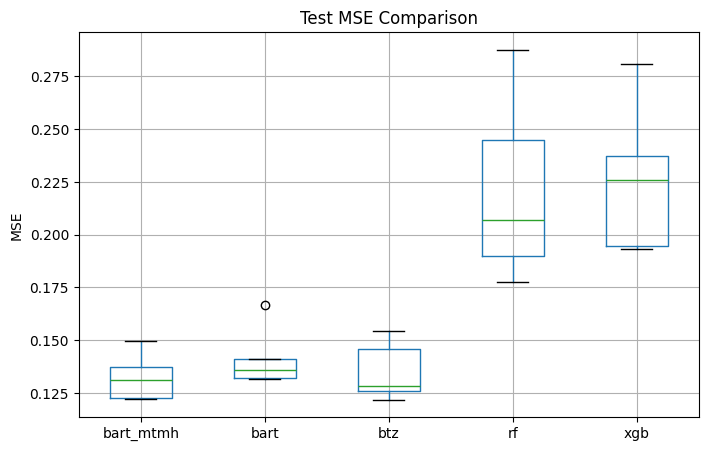

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
test_mse_df.boxplot()
plt.title("Test MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

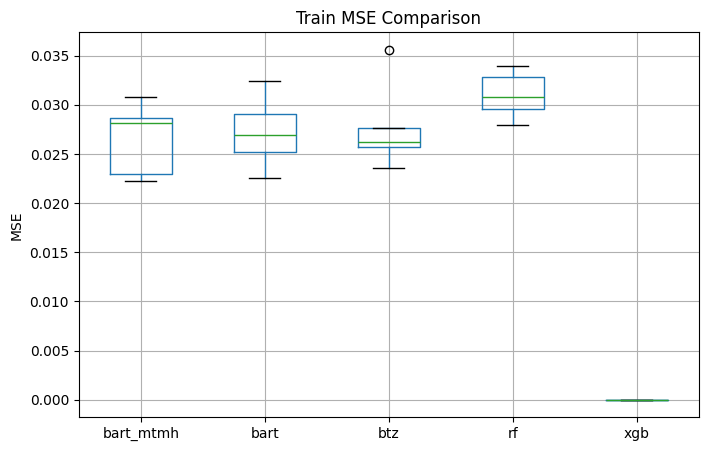

In [18]:
plt.figure(figsize=(8, 5))
train_mse_df.boxplot()
plt.title("Train MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

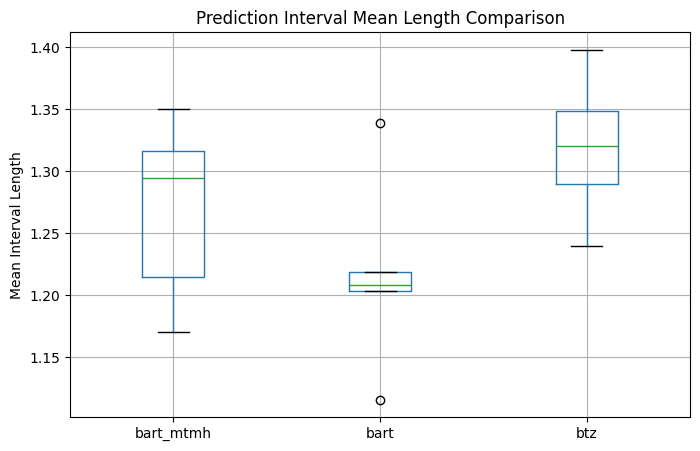

In [19]:
plt.figure(figsize=(8, 5))
pi_length_df.boxplot()
plt.title("Prediction Interval Mean Length Comparison")
plt.ylabel("Mean Interval Length")
plt.grid(True, axis='y')
plt.show()

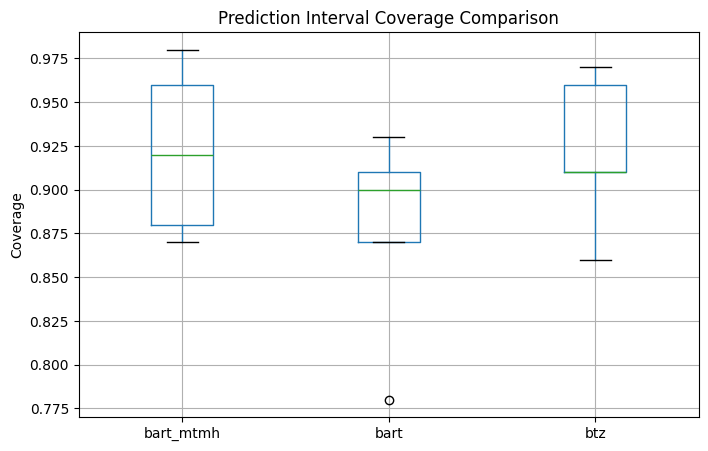

In [20]:
plt.figure(figsize=(8, 5))
coverage_df.boxplot()
plt.title("Prediction Interval Coverage Comparison")
plt.ylabel("Coverage")
plt.grid(True, axis='y')
plt.show()

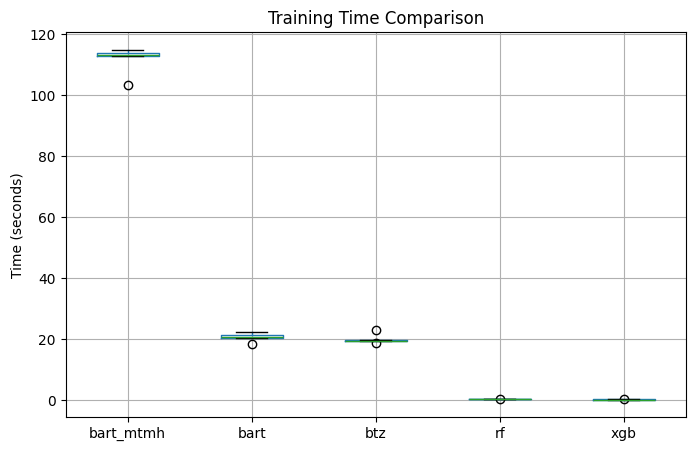

In [21]:
plt.figure(figsize=(8, 5))
time_df.boxplot()
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(True, axis='y')
plt.show()